# Planetary Imagery

The `S1FloodFinder`` package uses Sentinel 1 Radiometrically Terrain Corrected (S1-RTC) imagery. To the best of my knowledge, these images are currently available only from <b>Microsoft Planetary Computer</b> platform. So, the first step is to provide a mechanism that can automate the fetch for our interest region. 
 
This notebook is only to show how to access the following imagery for a specific area.

In [35]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import contextily as cx
from flood_finder.imagery import ImageFinder
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Select a ROI

To select a region of interest, we can make use of the `geojson.io` interactive map that outputs the `GeoJson` representation of a polygon. In the following example, I've created a Polygon (box) around the city of Alegrete-RS, Brazil. This ROI is a Feature Collection and we want the geometry as a `shapely` `Polygon`.

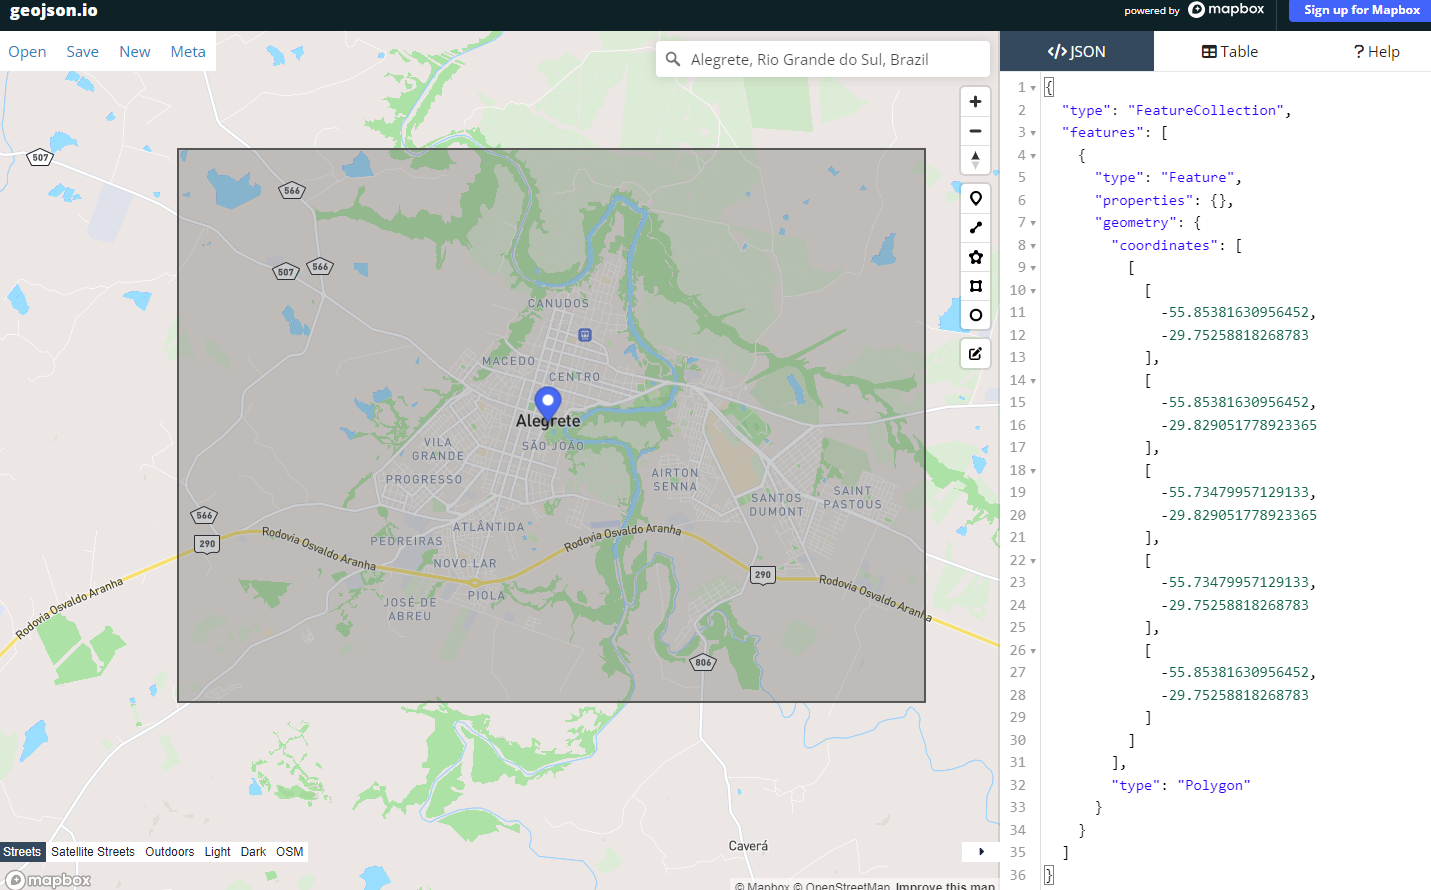

In [5]:
roi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -55.85381630956452,
              -29.75258818268783
            ],
            [
              -55.85381630956452,
              -29.829051778923365
            ],
            [
              -55.73479957129133,
              -29.829051778923365
            ],
            [
              -55.73479957129133,
              -29.75258818268783
            ],
            [
              -55.85381630956452,
              -29.75258818268783
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [16]:
# write the ROI to a GeoDataFrame
# PS: We need to make sure the Coordinate Reference System is set
gdf = gpd.GeoDataFrame.from_features(roi).set_crs('epsg:4326')

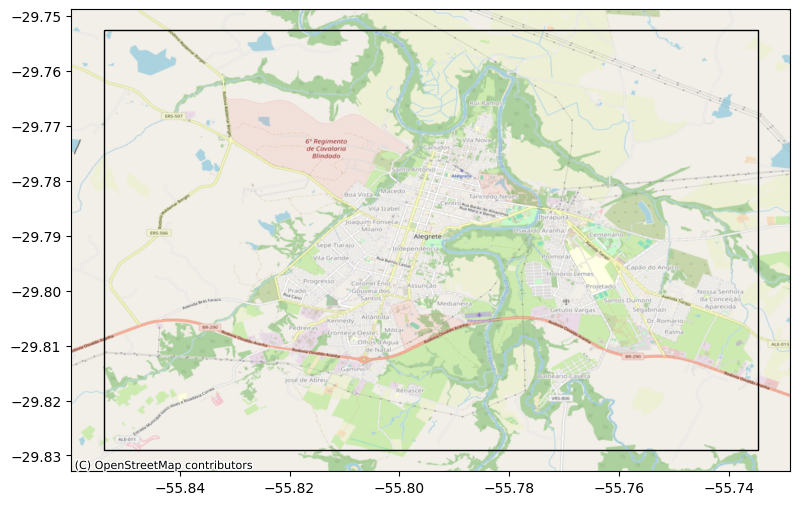

In [23]:
# Plot a context map using contextily
ax = gdf.plot(facecolor='none', figsize=(12, 6))
cx.add_basemap(ax=ax, crs=gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

## ImageFinder Class

Now that we have our Region of Interest, let's use the `ImageFinder` class to search for Sentinel 1 imagery within the desired period. The images are mosaicked and grouped by date automatically. 

Once the images are "located", they can be plotted in False Color by combining the `VV` and `VH` polarizations. This is done "under-the-hood" by the `S1Imagery` class, that applies also the LeeFilter for speckle noise filtering. 

In [34]:
# create a ImageFinder instance
imagefinder = ImageFinder(subscription_key='60c2795c5764470ca21438274583378d')

s1imagery = imagefinder.get_s1_images(
    aoi=gdf.geometry[0],
    time_range='2018-12/2019-02',
    lee_size=7,
    shape=None,
)

s1imagery

S1Imagery Class with 9 dates

In [33]:
s1imagery.dates

array(['2019-02-23', '2019-02-11', '2019-01-30', '2019-01-18',
       '2019-01-15', '2019-01-06', '2018-12-25', '2018-12-13',
       '2018-12-01'], dtype=object)

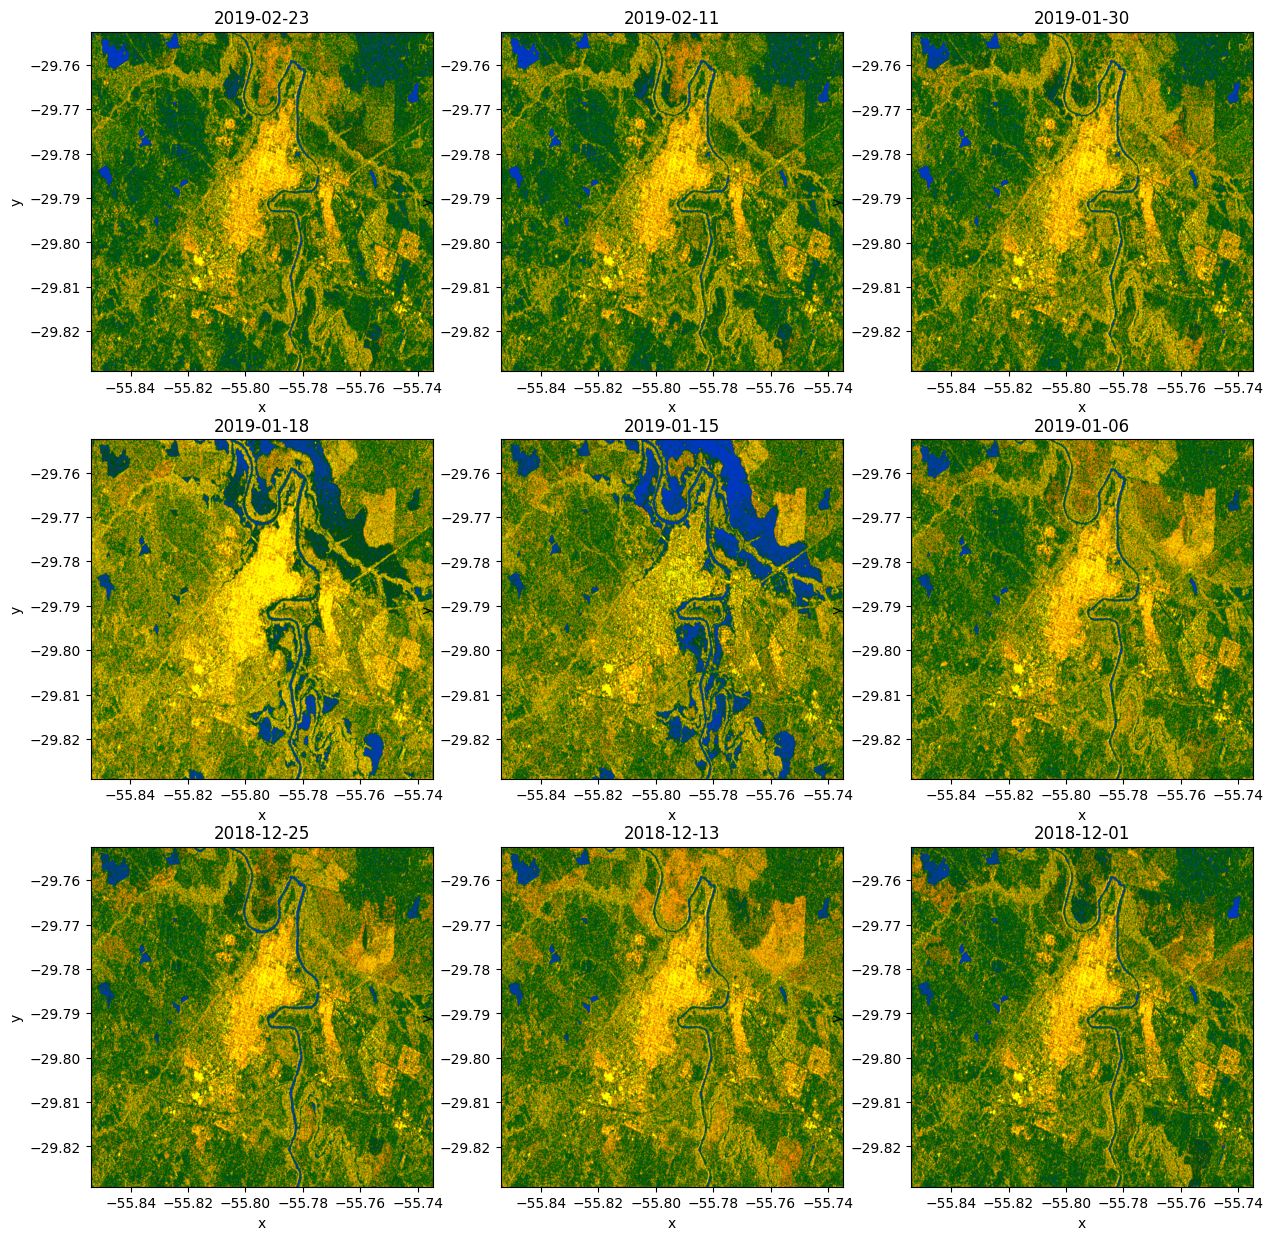

In [39]:
fig, axs = plt.subplots(3,3, figsize=(15,15))

for idx, ax in enumerate(axs.reshape(-1)):
    date = s1imagery.dates[idx]
    s1imagery.plot_date(date, ax=ax, raw=True)


## Downloading Water Occurrence

Next import step to detect floods is to retrieve the water baseline. We will use the Global Surface Water (Pekel et al. 2016) Recurrence layer that's also available on Planetary Computer. 

In [41]:
baseline = imagefinder.get_water_baseline(
    aoi=gdf.geometry[0],
    asset='recurrence'
)

baseline

<xarray.DataArray 'stackstac-8998b3027fd1d652d1682dd94ec44060' (y: 307, x: 477)>
dask.array<getitem, shape=(307, 477), dtype=float64, chunksize=(307, 477), chunktype=numpy.ndarray>
Coordinates: (12/14)
    band            <U10 'recurrence'
  * x               (x) float64 -55.85 -55.85 -55.85 ... -55.74 -55.74 -55.73
  * y               (y) float64 -29.75 -29.75 -29.75 ... -29.83 -29.83 -29.83
    proj:bbox       object {-30.0, -60.0, -20.0, -50.0}
    start_datetime  <U20 '1984-03-01T00:00:00Z'
    proj:epsg       int64 4326
    ...              ...
    proj:shape      object {40000}
    end_datetime    <U20 '2020-12-31T11:59:59Z'
    sci:doi         <U19 '10.1038/nature20584'
    description     <U146 'Provides information concerning the inter-annual b...
    title           <U16 'Water Recurrence'
    epsg            int64 4326

Note that the recurrence is retrieved as a lazy `XArray` object. To display it, we can use the `Plot` function from XArray.

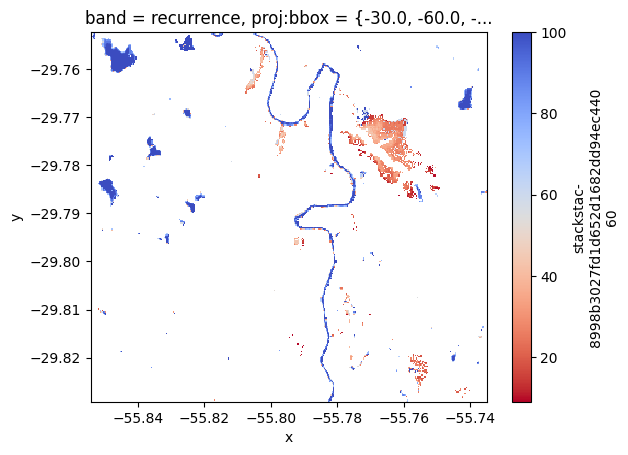

In [45]:
baseline.plot(cmap='coolwarm_r')